DETR Object Detection Training
Configuration:
  data_dir: /home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco
  batch_size: 8
  num_epochs: 1
  learning_rate: 0.0001
  weight_decay: 0.0001
  num_queries: 100
  hidden_dim: 256
  num_workers: 4
  device: cuda
Loading datasets...
Train samples: 5806
Validation samples: 1628
Test samples: 829
Number of classes: 6
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']

Initializing model...
Total parameters: 35,251,787
Trainable parameters: 35,251,787

Starting training...
Training DETR model for 1 epochs...
Device: cuda
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
------------------------------------------------------------


Epoch 1/1 [Train]: 100%|█| 726/726 [06:14<00:00,  1.94it/s, Loss=3.7861, CE=0.50
Epoch 1/1 [Val]: 100%|█| 204/204 [00:34<00:00,  5.93it/s, Loss=5.3183, CE=0.7690


Epoch 1/1:
  Train Loss: 3.5788
  Val Loss: 5.7518
  Learning Rate: 0.000100
  New best validation loss: 5.7518
------------------------------------------------------------


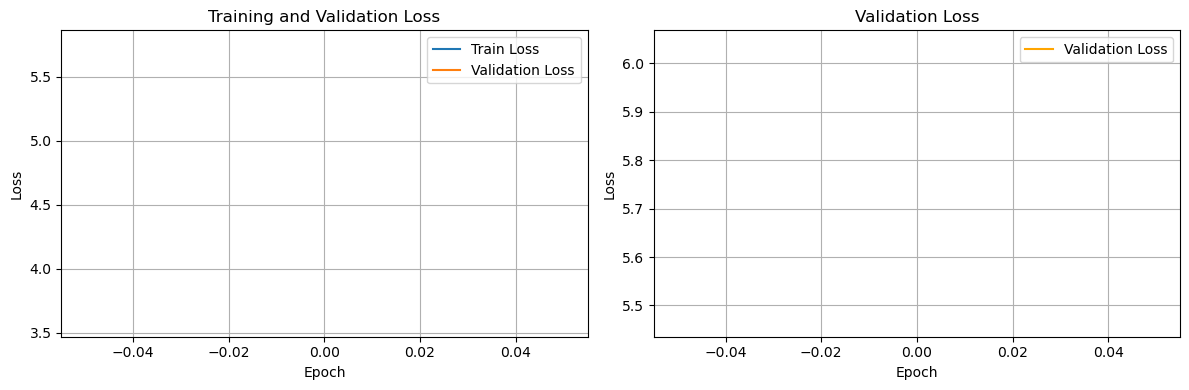


Evaluating model...
Starting comprehensive evaluation...
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
------------------------------------------------------------


Evaluating: 100%|█████████████████████████████| 104/104 [00:17<00:00,  5.97it/s]



Evaluation Results:

IoU Threshold: 0.5
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.55
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.6
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.65
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.7
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-:

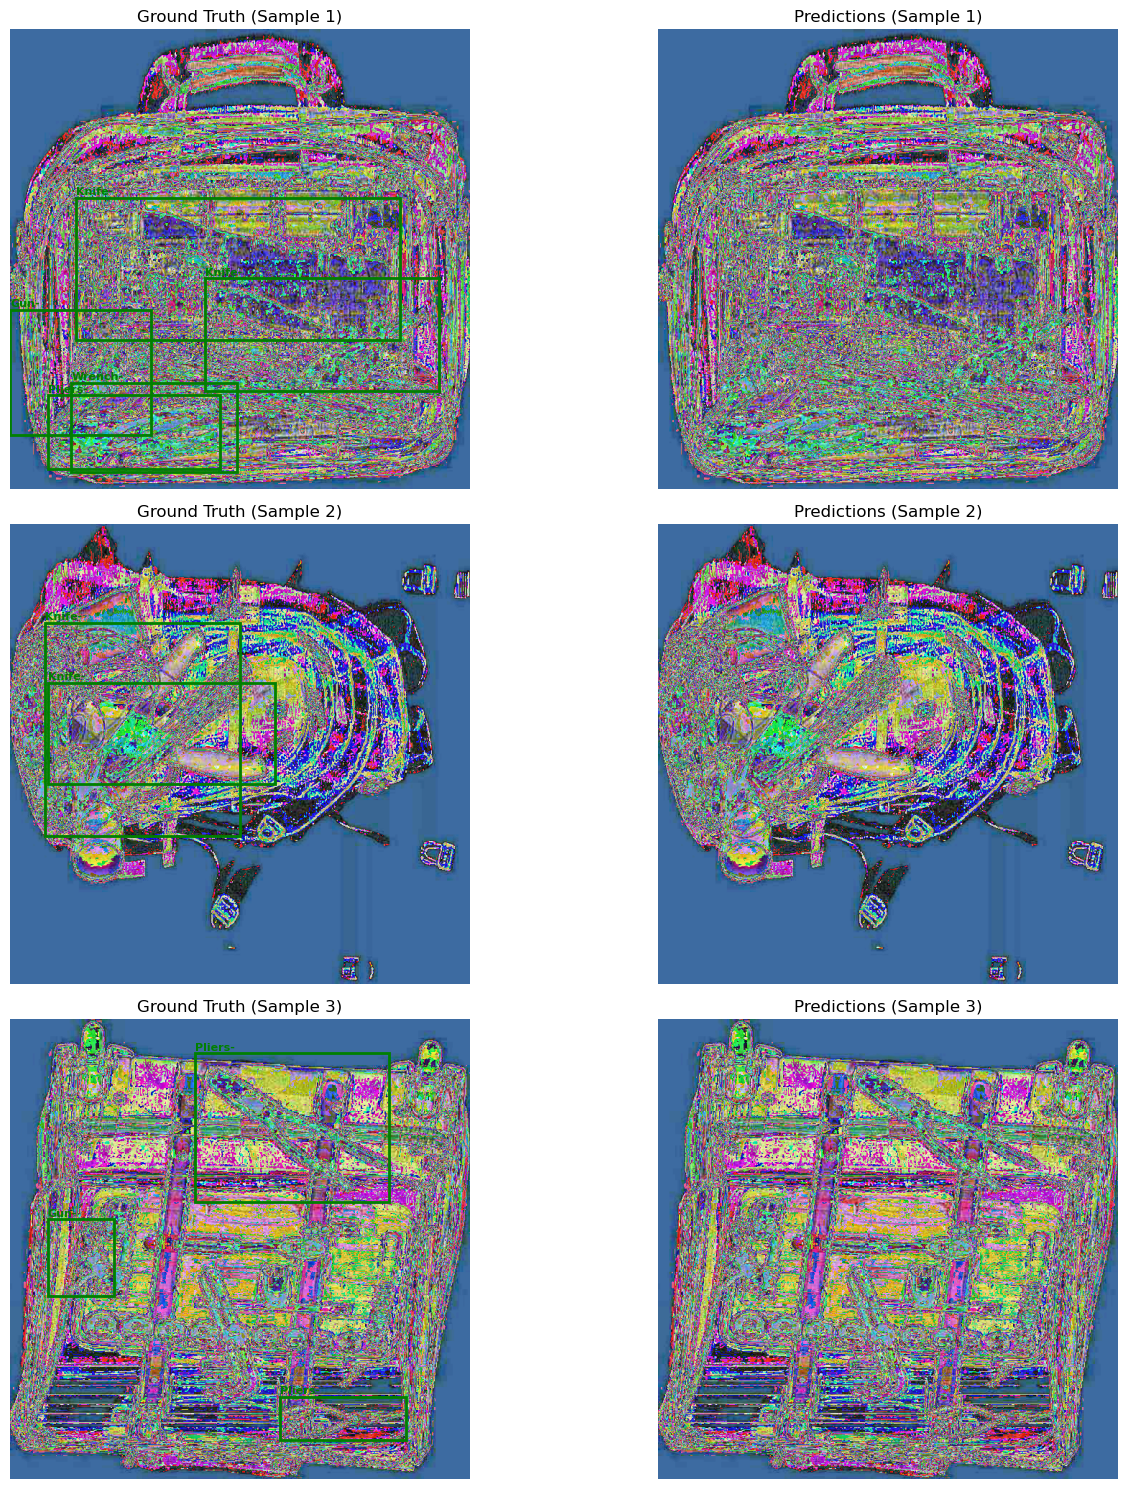


Training completed!
Model is ready for inference.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import json
import os
from PIL import Image
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# MLP Class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

# DETR Model Components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
    def forward(self, src, src_key_padding_mask=None):
        return self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super().__init__()
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
    def forward(self, tgt, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return self.transformer_decoder(
            tgt, memory, 
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

class DETR(nn.Module):
    def __init__(self, num_classes, num_queries=100, hidden_dim=256, nheads=8, 
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.num_queries = num_queries
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        
        # Backbone
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        
        # Reduce channel dimensions
        self.input_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(hidden_dim)
        
        # Transformer
        self.transformer_encoder = TransformerEncoder(
            hidden_dim, nheads, num_encoder_layers, hidden_dim * 4
        )
        self.transformer_decoder = TransformerDecoder(
            hidden_dim, nheads, num_decoder_layers, hidden_dim * 4
        )
        
        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        
        # Prediction heads
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        
    def forward(self, x):
        # Extract features with backbone
        features = self.backbone.conv1(x)
        features = self.backbone.bn1(features)
        features = self.backbone.relu(features)
        features = self.backbone.maxpool(features)
        
        features = self.backbone.layer1(features)
        features = self.backbone.layer2(features)
        features = self.backbone.layer3(features)
        features = self.backbone.layer4(features)
        
        # Reduce dimensions
        features = self.input_proj(features)
        
        # Flatten spatial dimensions
        bs, c, h, w = features.shape
        features = features.flatten(2).permute(0, 2, 1)  # [bs, hw, c]
        
        # Add positional encoding
        features = self.pos_encoding(features)
        
        # Encoder
        memory = self.transformer_encoder(features)
        
        # Decoder
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(bs, 1, 1)
        tgt = torch.zeros_like(query_embed)
        
        hs = self.transformer_decoder(tgt, memory)
        
        # Predictions
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        
        return {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

# Dataset Class
class SixRayDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None, target_size=(640, 640)):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.target_size = target_size
        
        # Load annotations
        ann_file = os.path.join(data_dir, split, '_annotations.coco.json')
        with open(ann_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create mappings
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.category_ids = list(self.categories.keys())
        
        # Group annotations by image
        self.image_annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_annotations[ann['image_id']].append(ann)
        
        self.image_ids = list(self.images.keys())
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # Load image
        img_path = os.path.join(self.data_dir, self.split, image_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # Get annotations
        annotations = self.image_annotations[image_id]
        
        # Prepare targets
        boxes = []
        labels = []
        
        for ann in annotations:
            # Convert COCO bbox format (x, y, w, h) to (x1, y1, x2, y2)
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.FloatTensor(boxes)
            labels = torch.LongTensor(labels)
            
            # Normalize boxes to [0, 1]
            orig_w, orig_h = image.size
            boxes[:, [0, 2]] /= orig_w
            boxes[:, [1, 3]] /= orig_h
            
            # Convert to center format (cx, cy, w, h)
            boxes_center = torch.zeros_like(boxes)
            boxes_center[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2  # cx
            boxes_center[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2  # cy
            boxes_center[:, 2] = boxes[:, 2] - boxes[:, 0]        # w
            boxes_center[:, 3] = boxes[:, 3] - boxes[:, 1]        # h
            boxes = boxes_center
        else:
            boxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id])
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Hungarian Matcher
class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=1, cost_giou=1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        
    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]
        
        # Flatten to compute the cost matrices
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_bbox = outputs["pred_boxes"].flatten(0, 1)
        
        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])
        
        # Compute the classification cost
        cost_class = -out_prob[:, tgt_ids]
        
        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        
        # Compute the giou cost between boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), 
                                        box_cxcywh_to_xyxy(tgt_bbox))
        
        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()
        
        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

# Loss Functions
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    iou, union = box_iou(boxes1, boxes2)
    
    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])
    
    wh = (rb - lt).clamp(min=0)
    area = wh[:, :, 0] * wh[:, :, 1]
    
    return iou - (area - union) / area

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        indices = self.matcher(outputs_without_aux, targets)

        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if torch.distributed.is_available() and torch.distributed.is_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / torch.distributed.get_world_size() if torch.distributed.is_initialized() else num_boxes, min=1).item()

        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

def accuracy(output, target, topk=(1,)):
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Evaluation Metrics
class CocoEvaluator:
    def __init__(self, categories):
        self.categories = categories
        self.reset()
    
    def reset(self):
        self.predictions = []
        self.ground_truths = []
    
    def update(self, predictions, targets):
        for pred, target in zip(predictions, targets):
            self.predictions.append(pred)
            self.ground_truths.append(target)
    
    def compute_metrics(self, iou_threshold=0.5):
        metrics = {}
        
        # Calculate AP for each class
        aps = []
        for cat_id in self.categories.keys():
            ap = self._calculate_ap(cat_id, iou_threshold)
            aps.append(ap)
            metrics[f'AP_{self.categories[cat_id]}'] = ap
        
        # Calculate mAP
        metrics['mAP'] = np.mean(aps) if aps else 0.0
        
        # Calculate other metrics
        precision, recall, f1 = self._calculate_precision_recall()
        metrics['Precision'] = precision
        metrics['Recall'] = recall
        metrics['F1-Score'] = f1
        
        return metrics
    
    def _calculate_ap(self, category_id, iou_threshold):
        # Collect all predictions and ground truths for this category
        pred_boxes = []
        pred_scores = []
        gt_boxes = []
        
        for pred, gt in zip(self.predictions, self.ground_truths):
            # Get predictions for this category
            if 'labels' in pred:
                mask = pred['labels'] == category_id
                if mask.any():
                    pred_boxes.extend(pred['boxes'][mask].cpu().numpy())
                    pred_scores.extend(pred['scores'][mask].cpu().numpy())
            
            # Get ground truths for this category
            if 'labels' in gt:
                mask = gt['labels'] == category_id
                if mask.any():
                    gt_boxes.extend(gt['boxes'][mask].cpu().numpy())
        
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            return 0.0
        
        # Calculate AP (simplified version)
        pred_boxes = np.array(pred_boxes)
        pred_scores = np.array(pred_scores)
        gt_boxes = np.array(gt_boxes)
        
        # Sort predictions by score
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]
        
        # Calculate precision and recall
        tp = np.zeros(len(pred_boxes))
        fp = np.zeros(len(pred_boxes))
        
        gt_matched = np.zeros(len(gt_boxes))
        
        for i, pred_box in enumerate(pred_boxes):
            # Calculate IoU with all ground truth boxes
            ious = []
            for gt_box in gt_boxes:
                iou = self._calculate_iou(pred_box, gt_box)
                ious.append(iou)
            
            if len(ious) > 0:
                max_iou = max(ious)
                max_idx = ious.index(max_iou)
                
                if max_iou >= iou_threshold and gt_matched[max_idx] == 0:
                    tp[i] = 1
                    gt_matched[max_idx] = 1
                else:
                    fp[i] = 1
            else:
                fp[i] = 1
        
        # Calculate precision and recall curves
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        recalls = tp_cumsum / len(gt_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
        
        # Calculate AP using 11-point interpolation
        ap = 0
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11.
        
        return ap
    
    def _calculate_iou(self, box1, box2):
        # Convert center format to corner format if needed
        if len(box1) == 4 and len(box2) == 4:
            # Assume boxes are in (cx, cy, w, h) format
            x1_min = box1[0] - box1[2] / 2
            y1_min = box1[1] - box1[3] / 2
            x1_max = box1[0] + box1[2] / 2
            y1_max = box1[1] + box1[3] / 2
            
            x2_min = box2[0] - box2[2] / 2
            y2_min = box2[1] - box2[3] / 2
            x2_max = box2[0] + box2[2] / 2
            y2_max = box2[1] + box2[3] / 2
            
            # Calculate intersection
            inter_x_min = max(x1_min, x2_min)
            inter_y_min = max(y1_min, y2_min)
            inter_x_max = min(x1_max, x2_max)
            inter_y_max = min(y1_max, y2_max)
            
            if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
                return 0.0
            
            inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
            
            # Calculate union
            box1_area = box1[2] * box1[3]
            box2_area = box2[2] * box2[3]
            union_area = box1_area + box2_area - inter_area
            
            return inter_area / union_area if union_area > 0 else 0.0
        
        return 0.0
    
    def _calculate_precision_recall(self):
        all_tp = 0
        all_fp = 0
        all_fn = 0
        
        for pred, gt in zip(self.predictions, self.ground_truths):
            if 'labels' in pred and 'labels' in gt:
                pred_labels = set(pred['labels'].cpu().numpy())
                gt_labels = set(gt['labels'].cpu().numpy())
                
                tp = len(pred_labels & gt_labels)
                fp = len(pred_labels - gt_labels)
                fn = len(gt_labels - pred_labels)
                
                all_tp += tp
                all_fp += fp
                all_fn += fn
        
        precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
        recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return precision, recall, f1

def evaluate_model(model, test_loader, categories, device):
    """Comprehensive evaluation function"""
    print("Starting comprehensive evaluation...")
    print(f"Categories: {list(categories.values())}")
    print("-" * 60)
    
    model.eval()
    
    # Multiple IoU thresholds for comprehensive evaluation
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    
    # Collect all predictions and targets
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Evaluating')
        
        for images, targets in test_pbar:
            images = images.to(device)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            # Convert outputs to evaluation format
            for i in range(len(targets)):
                pred_logits = outputs['pred_logits'][i]
                pred_boxes = outputs['pred_boxes'][i]
                
                # Get predictions above threshold
                scores = F.softmax(pred_logits, dim=-1)
                scores, labels = scores[..., :-1].max(-1)
                
                # Filter by confidence threshold
                keep = scores > 0.3  # Lower threshold for evaluation
                
                pred_dict = {
                    'boxes': pred_boxes[keep],
                    'labels': labels[keep] + 1,  # Convert to 1-based indexing
                    'scores': scores[keep]
                }
                all_predictions.append(pred_dict)
                all_targets.append(targets[i])
    
    # Evaluate at different IoU thresholds
    print("\nEvaluation Results:")
    print("=" * 60)
    
    results = {}
    for iou_thresh in iou_thresholds:
        evaluator = CocoEvaluator(categories)
        evaluator.predictions = all_predictions
        evaluator.ground_truths = all_targets
        
        metrics = evaluator.compute_metrics(iou_threshold=iou_thresh)
        results[iou_thresh] = metrics
        
        print(f"\nIoU Threshold: {iou_thresh}")
        print(f"mAP: {metrics['mAP']:.4f}")
        print(f"Precision: {metrics['Precision']:.4f}")
        print(f"Recall: {metrics['Recall']:.4f}")
        print(f"F1-Score: {metrics['F1-Score']:.4f}")
        
        # Per-class AP
        for cat_id, cat_name in categories.items():
            if f'AP_{cat_name}' in metrics:
                print(f"  AP_{cat_name}: {metrics[f'AP_{cat_name}']:.4f}")
    
    # Calculate COCO-style mAP (average over IoU thresholds 0.5:0.95)
    coco_map = np.mean([results[thresh]['mAP'] for thresh in iou_thresholds])
    print(f"\nCOCO-style mAP (0.5:0.95): {coco_map:.4f}")
    
    # Additional metrics
    print("\n" + "=" * 60)
    print("SUMMARY METRICS")
    print("=" * 60)
    print(f"mAP@0.5: {results[0.5]['mAP']:.4f}")
    print(f"mAP@0.75: {results[0.75]['mAP']:.4f}")
    print(f"mAP@0.5:0.95: {coco_map:.4f}")
    print(f"Best Precision: {max([results[thresh]['Precision'] for thresh in iou_thresholds]):.4f}")
    print(f"Best Recall: {max([results[thresh]['Recall'] for thresh in iou_thresholds]):.4f}")
    print(f"Best F1-Score: {max([results[thresh]['F1-Score'] for thresh in iou_thresholds]):.4f}")
    
    return results

def visualize_predictions(model, test_dataset, categories, device, num_samples=5):
    """Visualize model predictions"""
    model.eval()
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(test_dataset))
            image, target = test_dataset[idx]
            
            # Prepare input
            image_tensor = image.unsqueeze(0).to(device)
            
            # Get prediction
            outputs = model(image_tensor)
            
            # Process predictions
            pred_logits = outputs['pred_logits'][0]
            pred_boxes = outputs['pred_boxes'][0]
            
            scores = F.softmax(pred_logits, dim=-1)
            scores, labels = scores[..., :-1].max(-1)
            
            # Filter predictions
            keep = scores > 0.5
            pred_boxes = pred_boxes[keep]
            pred_labels = labels[keep]
            pred_scores = scores[keep]
            
            # Convert image to numpy for visualization
            if isinstance(image, torch.Tensor):
                img_np = image.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(image)
            
            # Plot original with ground truth
            axes[i][0].imshow(img_np)
            axes[i][0].set_title(f'Ground Truth (Sample {i+1})')
            axes[i][0].axis('off')
            
            # Draw ground truth boxes
            h, w = img_np.shape[:2]
            for box, label in zip(target['boxes'], target['labels']):
                if len(box) > 0:
                    # Convert from center format to corner format
                    cx, cy, bw, bh = box
                    x1 = (cx - bw/2) * w
                    y1 = (cy - bh/2) * h
                    x2 = (cx + bw/2) * w
                    y2 = (cy + bh/2) * h
                    
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       fill=False, color='green', linewidth=2)
                    axes[i][0].add_patch(rect)
                    
                    # Add label
                    cat_name = categories.get(label.item(), f'Class_{label.item()}')
                    axes[i][0].text(x1, y1-5, cat_name, 
                                  color='green', fontsize=8, weight='bold')
            
            # Plot predictions
            axes[i][1].imshow(img_np)
            axes[i][1].set_title(f'Predictions (Sample {i+1})')
            axes[i][1].axis('off')
            
            # Draw predicted boxes
            for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                # Convert from center format to corner format
                cx, cy, bw, bh = box
                x1 = (cx - bw/2) * w
                y1 = (cy - bh/2) * h
                x2 = (cx + bw/2) * w
                y2 = (cy + bh/2) * h
                
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   fill=False, color='red', linewidth=2)
                axes[i][1].add_patch(rect)
                
                # Add label with confidence
                cat_name = categories.get((label+1).item(), f'Class_{(label+1).item()}')
                axes[i][1].text(x1, y1-5, f'{cat_name}: {score:.2f}', 
                              color='red', fontsize=8, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, categories):
    """Train the DETR model"""
    print(f"Training DETR model for {num_epochs} epochs...")
    print(f"Device: {device}")
    print(f"Categories: {list(categories.values())}")
    print("-" * 60)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch_idx, (images, targets) in enumerate(train_pbar):
            images = images.to(device)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            
            # Calculate total loss
            losses = sum(loss_dict[k] * criterion.weight_dict[k] 
                        for k in loss_dict.keys() if k in criterion.weight_dict)
            
            losses.backward()
            optimizer.step()
            
            train_loss += losses.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{losses.item():.4f}',
                'CE': f'{loss_dict.get("loss_ce", 0):.4f}',
                'BBox': f'{loss_dict.get("loss_bbox", 0):.4f}',
                'GIoU': f'{loss_dict.get("loss_giou", 0):.4f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        
        with torch.no_grad():
            for images, targets in val_pbar:
                images = images.to(device)
                targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                           for k, v in t.items()} for t in targets]
                
                outputs = model(images)
                loss_dict = criterion(outputs, targets)
                
                losses = sum(loss_dict[k] * criterion.weight_dict[k] 
                           for k in loss_dict.keys() if k in criterion.weight_dict)
                
                val_loss += losses.item()
                
                # Update progress bar
                val_pbar.set_postfix({
                    'Loss': f'{losses.item():.4f}',
                    'CE': f'{loss_dict.get("loss_ce", 0):.4f}',
                    'BBox': f'{loss_dict.get("loss_bbox", 0):.4f}',
                    'GIoU': f'{loss_dict.get("loss_giou", 0):.4f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"  New best validation loss: {best_val_loss:.4f}")
        
        print("-" * 60)
    
    return train_losses, val_losses

# Main execution function
def main():
    # Configuration
    CONFIG = {
        'data_dir': '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco',  # Update this path
        'batch_size': 8,
        'num_epochs': 1,
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'num_queries': 100,
        'hidden_dim': 256,
        'num_workers': 4,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    
    print("DETR Object Detection Training")
    print("=" * 50)
    print(f"Configuration:")
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")
    print("=" * 50)
    
    device = torch.device(CONFIG['device'])
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    print("Loading datasets...")
    train_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='train', 
        transform=train_transform
    )
    
    val_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='valid', 
        transform=val_transform
    )
    
    test_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='test', 
        transform=val_transform
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Get categories
    categories = train_dataset.categories
    num_classes = len(categories)
    print(f"Number of classes: {num_classes}")
    print(f"Categories: {list(categories.values())}")
    
    # Create data loaders
    def collate_fn(batch):
        images, targets = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        return images, targets
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=True, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=False, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=False, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    # Create model
    print("\nInitializing model...")
    model = DETR(
        num_classes=num_classes,
        num_queries=CONFIG['num_queries'],
        hidden_dim=CONFIG['hidden_dim']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Create criterion
    matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    losses = ['labels', 'boxes']
    
    criterion = SetCriterion(
        num_classes=num_classes,
        matcher=matcher,
        weight_dict=weight_dict,
        eos_coef=0.1,
        losses=losses
    ).to(device)
    
    # Create optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=30, 
        gamma=0.1
    )
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=CONFIG['num_epochs'],
        device=device,
        categories=categories
    )
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate model
    print("\nEvaluating model...")
    evaluation_results = evaluate_model(model, test_loader, categories, device)
    
    # Visualize predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, test_dataset, categories, device, num_samples=3)
    
    print("\nTraining completed!")
    print("Model is ready for inference.")

if __name__ == "__main__":
    main()

DETR Object Detection Training
Configuration:
  data_dir: /home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco
  batch_size: 8
  num_epochs: 5
  learning_rate: 0.0001
  weight_decay: 0.0001
  num_queries: 100
  hidden_dim: 256
  num_workers: 4
  device: cuda
Loading datasets...
Train samples: 5806
Validation samples: 1628
Test samples: 829
Number of classes: 6
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']

Initializing model...
Total parameters: 35,251,787
Trainable parameters: 35,251,787

Starting training...
Training DETR model for 5 epochs...
Device: cuda
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
------------------------------------------------------------


Epoch 1/5 [Train]: 100%|█| 726/726 [06:16<00:00,  1.93it/s, Loss=2.8213, CE=0.65
Epoch 1/5 [Val]: 100%|█| 204/204 [00:34<00:00,  5.90it/s, Loss=5.9788, CE=0.8038


Epoch 1/5:
  Train Loss: 3.5950
  Val Loss: 6.0602
  Learning Rate: 0.000100
  New best validation loss: 6.0602
------------------------------------------------------------


Epoch 2/5 [Train]: 100%|█| 726/726 [06:19<00:00,  1.92it/s, Loss=2.7242, CE=0.53
Epoch 2/5 [Val]: 100%|█| 204/204 [00:34<00:00,  5.89it/s, Loss=5.9271, CE=0.7357


Epoch 2/5:
  Train Loss: 2.9586
  Val Loss: 5.7950
  Learning Rate: 0.000100
  New best validation loss: 5.7950
------------------------------------------------------------


Epoch 3/5 [Train]: 100%|█| 726/726 [06:19<00:00,  1.91it/s, Loss=3.4572, CE=0.54
Epoch 3/5 [Val]: 100%|█| 204/204 [00:34<00:00,  5.88it/s, Loss=7.1563, CE=0.7503


Epoch 3/5:
  Train Loss: 2.8983
  Val Loss: 7.1959
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 4/5 [Train]: 100%|█| 726/726 [06:19<00:00,  1.91it/s, Loss=2.9871, CE=0.66
Epoch 4/5 [Val]: 100%|█| 204/204 [00:34<00:00,  5.89it/s, Loss=5.2727, CE=0.7392


Epoch 4/5:
  Train Loss: 2.8636
  Val Loss: 6.0435
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 5/5 [Train]: 100%|█| 726/726 [06:23<00:00,  1.89it/s, Loss=2.9690, CE=0.68
Epoch 5/5 [Val]: 100%|█| 204/204 [00:34<00:00,  5.89it/s, Loss=5.4996, CE=0.7080


Epoch 5/5:
  Train Loss: 2.8639
  Val Loss: 6.2263
  Learning Rate: 0.000100
------------------------------------------------------------


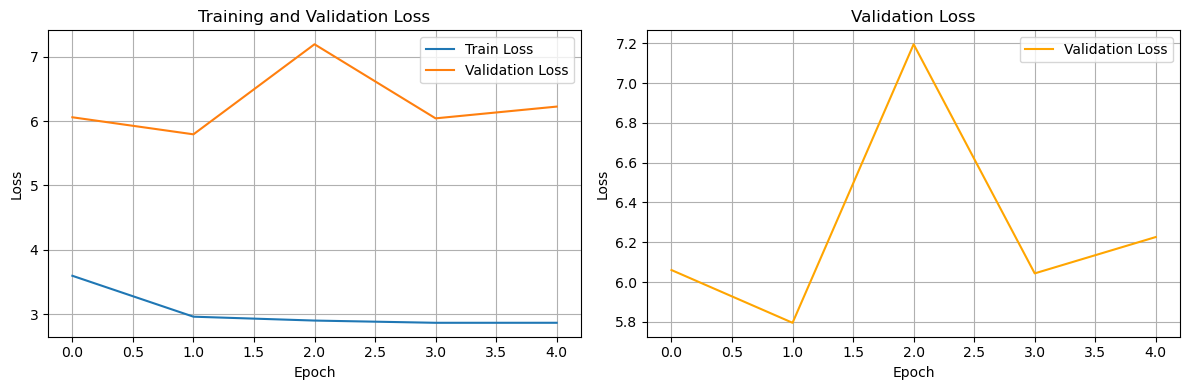


Evaluating model...
Starting comprehensive evaluation...
Categories: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
------------------------------------------------------------


Evaluating: 100%|█████████████████████████████| 104/104 [00:17<00:00,  5.92it/s]



Evaluation Results:

IoU Threshold: 0.5
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.55
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.6
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.65
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-: 0.0000
  AP_Knife-: 0.0000
  AP_Pliers-: 0.0000
  AP_Scissors-: 0.0000
  AP_Wrench-: 0.0000

IoU Threshold: 0.7
mAP: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
  AP_dangerous_goods: 0.0000
  AP_Gun-:

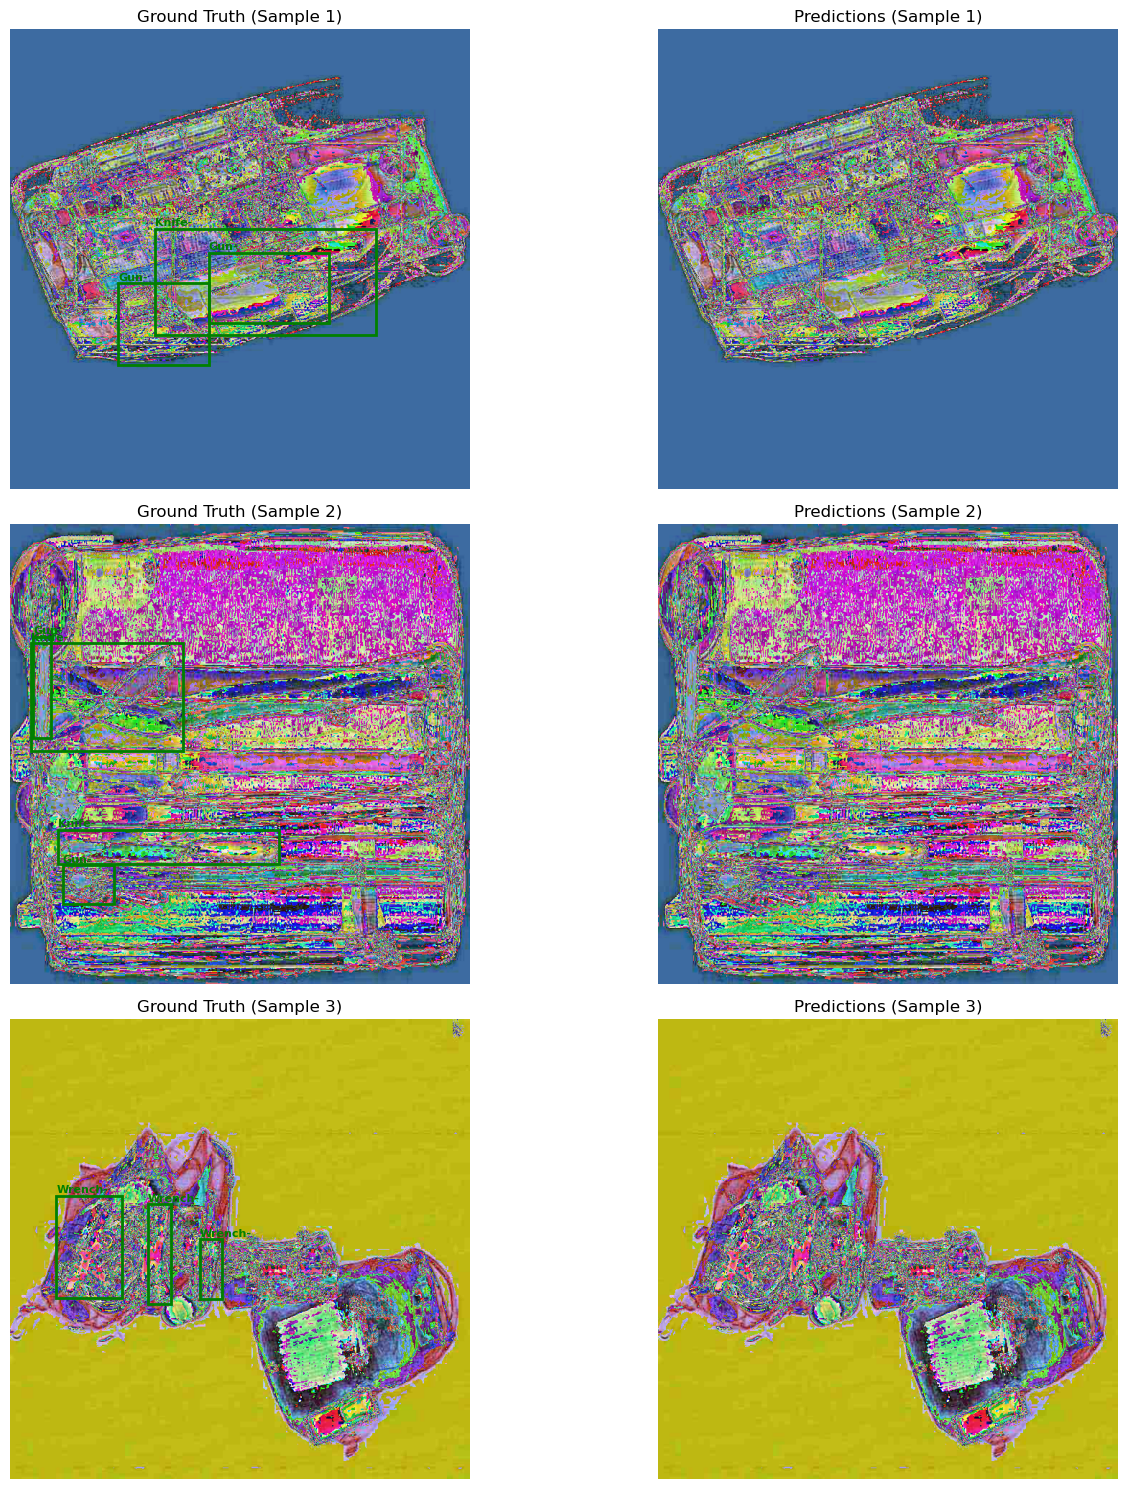


Training completed!
Model is ready for inference.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
import json
import os
from PIL import Image
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# MLP Class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

# DETR Model Components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
    def forward(self, src, src_key_padding_mask=None):
        return self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super().__init__()
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
    def forward(self, tgt, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return self.transformer_decoder(
            tgt, memory, 
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

class DETR(nn.Module):
    def __init__(self, num_classes, num_queries=100, hidden_dim=256, nheads=8, 
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.num_queries = num_queries
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        
        # Backbone
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        
        # Reduce channel dimensions
        self.input_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(hidden_dim)
        
        # Transformer
        self.transformer_encoder = TransformerEncoder(
            hidden_dim, nheads, num_encoder_layers, hidden_dim * 4
        )
        self.transformer_decoder = TransformerDecoder(
            hidden_dim, nheads, num_decoder_layers, hidden_dim * 4
        )
        
        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        
        # Prediction heads
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)  # +1 for no-object
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        
    def forward(self, x):
        # Extract features with backbone
        features = self.backbone.conv1(x)
        features = self.backbone.bn1(features)
        features = self.backbone.relu(features)
        features = self.backbone.maxpool(features)
        
        features = self.backbone.layer1(features)
        features = self.backbone.layer2(features)
        features = self.backbone.layer3(features)
        features = self.backbone.layer4(features)
        
        # Reduce dimensions
        features = self.input_proj(features)
        
        # Flatten spatial dimensions
        bs, c, h, w = features.shape
        features = features.flatten(2).permute(0, 2, 1)  # [bs, hw, c]
        
        # Add positional encoding
        features = self.pos_encoding(features)
        
        # Encoder
        memory = self.transformer_encoder(features)
        
        # Decoder
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(bs, 1, 1)
        tgt = torch.zeros_like(query_embed)
        
        hs = self.transformer_decoder(tgt, memory)
        
        # Predictions
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        
        return {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

# Dataset Class
class SixRayDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None, target_size=(640, 640)):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.target_size = target_size
        
        # Load annotations
        ann_file = os.path.join(data_dir, split, '_annotations.coco.json')
        with open(ann_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create mappings
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.category_ids = list(self.categories.keys())
        
        # Group annotations by image
        self.image_annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_annotations[ann['image_id']].append(ann)
        
        self.image_ids = list(self.images.keys())
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # Load image
        img_path = os.path.join(self.data_dir, self.split, image_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # Get annotations
        annotations = self.image_annotations[image_id]
        
        # Prepare targets
        boxes = []
        labels = []
        
        for ann in annotations:
            # Convert COCO bbox format (x, y, w, h) to (x1, y1, x2, y2)
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.FloatTensor(boxes)
            labels = torch.LongTensor(labels)
            
            # Normalize boxes to [0, 1]
            orig_w, orig_h = image.size
            boxes[:, [0, 2]] /= orig_w
            boxes[:, [1, 3]] /= orig_h
            
            # Convert to center format (cx, cy, w, h)
            boxes_center = torch.zeros_like(boxes)
            boxes_center[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2  # cx
            boxes_center[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2  # cy
            boxes_center[:, 2] = boxes[:, 2] - boxes[:, 0]        # w
            boxes_center[:, 3] = boxes[:, 3] - boxes[:, 1]        # h
            boxes = boxes_center
        else:
            boxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id])
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Hungarian Matcher
class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=1, cost_giou=1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        
    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]
        
        # Flatten to compute the cost matrices
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_bbox = outputs["pred_boxes"].flatten(0, 1)
        
        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])
        
        # Compute the classification cost
        cost_class = -out_prob[:, tgt_ids]
        
        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        
        # Compute the giou cost between boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), 
                                        box_cxcywh_to_xyxy(tgt_bbox))
        
        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()
        
        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

# Loss Functions
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    iou, union = box_iou(boxes1, boxes2)
    
    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])
    
    wh = (rb - lt).clamp(min=0)
    area = wh[:, :, 0] * wh[:, :, 1]
    
    return iou - (area - union) / area

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'boxes': self.loss_boxes,
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        indices = self.matcher(outputs_without_aux, targets)

        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if torch.distributed.is_available() and torch.distributed.is_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / torch.distributed.get_world_size() if torch.distributed.is_initialized() else num_boxes, min=1).item()

        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

def accuracy(output, target, topk=(1,)):
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Evaluation Metrics
class CocoEvaluator:
    def __init__(self, categories):
        self.categories = categories
        self.reset()
    
    def reset(self):
        self.predictions = []
        self.ground_truths = []
    
    def update(self, predictions, targets):
        for pred, target in zip(predictions, targets):
            self.predictions.append(pred)
            self.ground_truths.append(target)
    
    def compute_metrics(self, iou_threshold=0.5):
        metrics = {}
        
        # Calculate AP for each class
        aps = []
        for cat_id in self.categories.keys():
            ap = self._calculate_ap(cat_id, iou_threshold)
            aps.append(ap)
            metrics[f'AP_{self.categories[cat_id]}'] = ap
        
        # Calculate mAP
        metrics['mAP'] = np.mean(aps) if aps else 0.0
        
        # Calculate other metrics
        precision, recall, f1 = self._calculate_precision_recall()
        metrics['Precision'] = precision
        metrics['Recall'] = recall
        metrics['F1-Score'] = f1
        
        return metrics
    
    def _calculate_ap(self, category_id, iou_threshold):
        # Collect all predictions and ground truths for this category
        pred_boxes = []
        pred_scores = []
        gt_boxes = []
        
        for pred, gt in zip(self.predictions, self.ground_truths):
            # Get predictions for this category
            if 'labels' in pred:
                mask = pred['labels'] == category_id
                if mask.any():
                    pred_boxes.extend(pred['boxes'][mask].cpu().numpy())
                    pred_scores.extend(pred['scores'][mask].cpu().numpy())
            
            # Get ground truths for this category
            if 'labels' in gt:
                mask = gt['labels'] == category_id
                if mask.any():
                    gt_boxes.extend(gt['boxes'][mask].cpu().numpy())
        
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            return 0.0
        
        # Calculate AP (simplified version)
        pred_boxes = np.array(pred_boxes)
        pred_scores = np.array(pred_scores)
        gt_boxes = np.array(gt_boxes)
        
        # Sort predictions by score
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]
        
        # Calculate precision and recall
        tp = np.zeros(len(pred_boxes))
        fp = np.zeros(len(pred_boxes))
        
        gt_matched = np.zeros(len(gt_boxes))
        
        for i, pred_box in enumerate(pred_boxes):
            # Calculate IoU with all ground truth boxes
            ious = []
            for gt_box in gt_boxes:
                iou = self._calculate_iou(pred_box, gt_box)
                ious.append(iou)
            
            if len(ious) > 0:
                max_iou = max(ious)
                max_idx = ious.index(max_iou)
                
                if max_iou >= iou_threshold and gt_matched[max_idx] == 0:
                    tp[i] = 1
                    gt_matched[max_idx] = 1
                else:
                    fp[i] = 1
            else:
                fp[i] = 1
        
        # Calculate precision and recall curves
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        recalls = tp_cumsum / len(gt_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
        
        # Calculate AP using 11-point interpolation
        ap = 0
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11.
        
        return ap
    
    def _calculate_iou(self, box1, box2):
        # Convert center format to corner format if needed
        if len(box1) == 4 and len(box2) == 4:
            # Assume boxes are in (cx, cy, w, h) format
            x1_min = box1[0] - box1[2] / 2
            y1_min = box1[1] - box1[3] / 2
            x1_max = box1[0] + box1[2] / 2
            y1_max = box1[1] + box1[3] / 2
            
            x2_min = box2[0] - box2[2] / 2
            y2_min = box2[1] - box2[3] / 2
            x2_max = box2[0] + box2[2] / 2
            y2_max = box2[1] + box2[3] / 2
            
            # Calculate intersection
            inter_x_min = max(x1_min, x2_min)
            inter_y_min = max(y1_min, y2_min)
            inter_x_max = min(x1_max, x2_max)
            inter_y_max = min(y1_max, y2_max)
            
            if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
                return 0.0
            
            inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
            
            # Calculate union
            box1_area = box1[2] * box1[3]
            box2_area = box2[2] * box2[3]
            union_area = box1_area + box2_area - inter_area
            
            return inter_area / union_area if union_area > 0 else 0.0
        
        return 0.0
    
    def _calculate_precision_recall(self):
        all_tp = 0
        all_fp = 0
        all_fn = 0
        
        for pred, gt in zip(self.predictions, self.ground_truths):
            if 'labels' in pred and 'labels' in gt:
                pred_labels = set(pred['labels'].cpu().numpy())
                gt_labels = set(gt['labels'].cpu().numpy())
                
                tp = len(pred_labels & gt_labels)
                fp = len(pred_labels - gt_labels)
                fn = len(gt_labels - pred_labels)
                
                all_tp += tp
                all_fp += fp
                all_fn += fn
        
        precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
        recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return precision, recall, f1

def evaluate_model(model, test_loader, categories, device):
    """Comprehensive evaluation function"""
    print("Starting comprehensive evaluation...")
    print(f"Categories: {list(categories.values())}")
    print("-" * 60)
    
    model.eval()
    
    # Multiple IoU thresholds for comprehensive evaluation
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    
    # Collect all predictions and targets
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Evaluating')
        
        for images, targets in test_pbar:
            images = images.to(device)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            # Convert outputs to evaluation format
            for i in range(len(targets)):
                pred_logits = outputs['pred_logits'][i]
                pred_boxes = outputs['pred_boxes'][i]
                
                # Get predictions above threshold
                scores = F.softmax(pred_logits, dim=-1)
                scores, labels = scores[..., :-1].max(-1)
                
                # Filter by confidence threshold
                keep = scores > 0.3  # Lower threshold for evaluation
                
                pred_dict = {
                    'boxes': pred_boxes[keep],
                    'labels': labels[keep] + 1,  # Convert to 1-based indexing
                    'scores': scores[keep]
                }
                all_predictions.append(pred_dict)
                all_targets.append(targets[i])
    
    # Evaluate at different IoU thresholds
    print("\nEvaluation Results:")
    print("=" * 60)
    
    results = {}
    for iou_thresh in iou_thresholds:
        evaluator = CocoEvaluator(categories)
        evaluator.predictions = all_predictions
        evaluator.ground_truths = all_targets
        
        metrics = evaluator.compute_metrics(iou_threshold=iou_thresh)
        results[iou_thresh] = metrics
        
        print(f"\nIoU Threshold: {iou_thresh}")
        print(f"mAP: {metrics['mAP']:.4f}")
        print(f"Precision: {metrics['Precision']:.4f}")
        print(f"Recall: {metrics['Recall']:.4f}")
        print(f"F1-Score: {metrics['F1-Score']:.4f}")
        
        # Per-class AP
        for cat_id, cat_name in categories.items():
            if f'AP_{cat_name}' in metrics:
                print(f"  AP_{cat_name}: {metrics[f'AP_{cat_name}']:.4f}")
    
    # Calculate COCO-style mAP (average over IoU thresholds 0.5:0.95)
    coco_map = np.mean([results[thresh]['mAP'] for thresh in iou_thresholds])
    print(f"\nCOCO-style mAP (0.5:0.95): {coco_map:.4f}")
    
    # Additional metrics
    print("\n" + "=" * 60)
    print("SUMMARY METRICS")
    print("=" * 60)
    print(f"mAP@0.5: {results[0.5]['mAP']:.4f}")
    print(f"mAP@0.75: {results[0.75]['mAP']:.4f}")
    print(f"mAP@0.5:0.95: {coco_map:.4f}")
    print(f"Best Precision: {max([results[thresh]['Precision'] for thresh in iou_thresholds]):.4f}")
    print(f"Best Recall: {max([results[thresh]['Recall'] for thresh in iou_thresholds]):.4f}")
    print(f"Best F1-Score: {max([results[thresh]['F1-Score'] for thresh in iou_thresholds]):.4f}")
    
    return results

def visualize_predictions(model, test_dataset, categories, device, num_samples=5):
    """Visualize model predictions"""
    model.eval()
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(test_dataset))
            image, target = test_dataset[idx]
            
            # Prepare input
            image_tensor = image.unsqueeze(0).to(device)
            
            # Get prediction
            outputs = model(image_tensor)
            
            # Process predictions
            pred_logits = outputs['pred_logits'][0]
            pred_boxes = outputs['pred_boxes'][0]
            
            scores = F.softmax(pred_logits, dim=-1)
            scores, labels = scores[..., :-1].max(-1)
            
            # Filter predictions
            keep = scores > 0.5
            pred_boxes = pred_boxes[keep]
            pred_labels = labels[keep]
            pred_scores = scores[keep]
            
            # Convert image to numpy for visualization
            if isinstance(image, torch.Tensor):
                img_np = image.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(image)
            
            # Plot original with ground truth
            axes[i][0].imshow(img_np)
            axes[i][0].set_title(f'Ground Truth (Sample {i+1})')
            axes[i][0].axis('off')
            
            # Draw ground truth boxes
            h, w = img_np.shape[:2]
            for box, label in zip(target['boxes'], target['labels']):
                if len(box) > 0:
                    # Convert from center format to corner format
                    cx, cy, bw, bh = box
                    x1 = (cx - bw/2) * w
                    y1 = (cy - bh/2) * h
                    x2 = (cx + bw/2) * w
                    y2 = (cy + bh/2) * h
                    
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       fill=False, color='green', linewidth=2)
                    axes[i][0].add_patch(rect)
                    
                    # Add label
                    cat_name = categories.get(label.item(), f'Class_{label.item()}')
                    axes[i][0].text(x1, y1-5, cat_name, 
                                  color='green', fontsize=8, weight='bold')
            
            # Plot predictions
            axes[i][1].imshow(img_np)
            axes[i][1].set_title(f'Predictions (Sample {i+1})')
            axes[i][1].axis('off')
            
            # Draw predicted boxes
            for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                # Convert from center format to corner format
                cx, cy, bw, bh = box
                x1 = (cx - bw/2) * w
                y1 = (cy - bh/2) * h
                x2 = (cx + bw/2) * w
                y2 = (cy + bh/2) * h
                
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   fill=False, color='red', linewidth=2)
                axes[i][1].add_patch(rect)
                
                # Add label with confidence
                cat_name = categories.get((label+1).item(), f'Class_{(label+1).item()}')
                axes[i][1].text(x1, y1-5, f'{cat_name}: {score:.2f}', 
                              color='red', fontsize=8, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, categories):
    """Train the DETR model"""
    print(f"Training DETR model for {num_epochs} epochs...")
    print(f"Device: {device}")
    print(f"Categories: {list(categories.values())}")
    print("-" * 60)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch_idx, (images, targets) in enumerate(train_pbar):
            images = images.to(device)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            
            # Calculate total loss
            losses = sum(loss_dict[k] * criterion.weight_dict[k] 
                        for k in loss_dict.keys() if k in criterion.weight_dict)
            
            losses.backward()
            optimizer.step()
            
            train_loss += losses.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{losses.item():.4f}',
                'CE': f'{loss_dict.get("loss_ce", 0):.4f}',
                'BBox': f'{loss_dict.get("loss_bbox", 0):.4f}',
                'GIoU': f'{loss_dict.get("loss_giou", 0):.4f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        
        with torch.no_grad():
            for images, targets in val_pbar:
                images = images.to(device)
                targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                           for k, v in t.items()} for t in targets]
                
                outputs = model(images)
                loss_dict = criterion(outputs, targets)
                
                losses = sum(loss_dict[k] * criterion.weight_dict[k] 
                           for k in loss_dict.keys() if k in criterion.weight_dict)
                
                val_loss += losses.item()
                
                # Update progress bar
                val_pbar.set_postfix({
                    'Loss': f'{losses.item():.4f}',
                    'CE': f'{loss_dict.get("loss_ce", 0):.4f}',
                    'BBox': f'{loss_dict.get("loss_bbox", 0):.4f}',
                    'GIoU': f'{loss_dict.get("loss_giou", 0):.4f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"  New best validation loss: {best_val_loss:.4f}")
        
        print("-" * 60)
    
    return train_losses, val_losses

# Main execution function
def main():
    # Configuration
    CONFIG = {
        'data_dir': '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco',  # Update this path
        'batch_size': 8,
        'num_epochs': 5,
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'num_queries': 100,
        'hidden_dim': 256,
        'num_workers': 4,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    
    print("DETR Object Detection Training")
    print("=" * 50)
    print(f"Configuration:")
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")
    print("=" * 50)
    
    device = torch.device(CONFIG['device'])
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    print("Loading datasets...")
    train_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='train', 
        transform=train_transform
    )
    
    val_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='valid', 
        transform=val_transform
    )
    
    test_dataset = SixRayDataset(
        CONFIG['data_dir'], 
        split='test', 
        transform=val_transform
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Get categories
    categories = train_dataset.categories
    num_classes = len(categories)
    print(f"Number of classes: {num_classes}")
    print(f"Categories: {list(categories.values())}")
    
    # Create data loaders
    def collate_fn(batch):
        images, targets = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        return images, targets
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=True, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=False, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG['batch_size'],
        shuffle=False, 
        num_workers=CONFIG['num_workers'],
        collate_fn=collate_fn
    )
    
    # Create model
    print("\nInitializing model...")
    model = DETR(
        num_classes=num_classes,
        num_queries=CONFIG['num_queries'],
        hidden_dim=CONFIG['hidden_dim']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Create criterion
    matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    losses = ['labels', 'boxes']
    
    criterion = SetCriterion(
        num_classes=num_classes,
        matcher=matcher,
        weight_dict=weight_dict,
        eos_coef=0.1,
        losses=losses
    ).to(device)
    
    # Create optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=30, 
        gamma=0.1
    )
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=CONFIG['num_epochs'],
        device=device,
        categories=categories
    )
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate model
    print("\nEvaluating model...")
    evaluation_results = evaluate_model(model, test_loader, categories, device)
    
    # Visualize predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, test_dataset, categories, device, num_samples=3)
    
    print("\nTraining completed!")
    print("Model is ready for inference.")

if __name__ == "__main__":
    main()